In [1]:
!pip install imbalanced-learn xgboost tensorflow scikit-learn pandas numpy matplotlib seaborn joblib

Data shape: (10000, 6)
fraud
0    9800
1     200
Name: count, dtype: int64
After SMOTE: [7840 7840]

Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1960
           1       0.98      1.00      0.99        40

    accuracy                           1.00      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      1.00      1.00      2000



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Autoencoder Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1960
           1       1.00      1.00      1.00        40

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1960
           1       0.98      1.00      0.99        40

    accuracy                           1.00      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC: 1.0
F1 Score: 0.9876543209876543


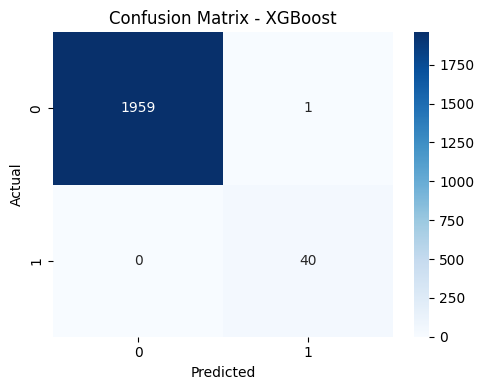

✅ Models saved in ./models/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import xgboost as xgb
import joblib

# -----------------------------
# 1) Synthetic Data Generation
# -----------------------------
def generate_fraud_data(n_samples=10000, fraud_ratio=0.02, random_state=42):
    np.random.seed(random_state)
    n_frauds = int(n_samples * fraud_ratio)
    n_normals = n_samples - n_frauds

    # Normal transactions
    normal = pd.DataFrame({
        'amount': np.random.gamma(2, 50, n_normals),
        'time_gap': np.random.exponential(1, n_normals),
        'merchant_score': np.random.normal(0.8, 0.1, n_normals),
        'transaction_type': np.random.choice(['online', 'in-store'], n_normals, p=[0.3, 0.7]),
        'region_risk': np.random.normal(0.2, 0.05, n_normals),
        'fraud': 0
    })

    # Fraudulent transactions
    fraud = pd.DataFrame({
        'amount': np.random.gamma(7, 120, n_frauds),
        'time_gap': np.random.exponential(5, n_frauds),
        'merchant_score': np.random.normal(0.4, 0.15, n_frauds),
        'transaction_type': np.random.choice(['online', 'in-store'], n_frauds, p=[0.9, 0.1]),
        'region_risk': np.random.normal(0.7, 0.1, n_frauds),
        'fraud': 1
    })
    df = pd.concat([normal, fraud], ignore_index=True)
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df

df = generate_fraud_data()
print("Data shape:", df.shape)
print(df['fraud'].value_counts())

# -----------------------------
# 2) Preprocessing
# -----------------------------
le = LabelEncoder()
df['transaction_type'] = le.fit_transform(df['transaction_type'])
X = df.drop('fraud', axis=1)
y = df['fraud']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------------
# 3) Handle Imbalance with SMOTE
# -----------------------------
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_sm))

# -----------------------------
# 4) Isolation Forest (Unsupervised)
# -----------------------------
iso = IsolationForest(contamination=0.02, random_state=42)
iso.fit(X_train)
y_pred_iso = iso.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)
print("\nIsolation Forest Results:")
print(classification_report(y_test, y_pred_iso, zero_division=0))

# -----------------------------
# 5) Autoencoder Model
# -----------------------------
input_dim = X_train.shape[1]
autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,)),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')

# Train only on normal transactions
X_train_norm = X_train[y_train == 0]
autoencoder.fit(X_train_norm, X_train_norm,
                epochs=20,
                batch_size=64,
                validation_split=0.1,
                verbose=0)

# Reconstruction error
recon = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - recon, 2), axis=1)
threshold = np.percentile(mse, 98)
y_pred_auto = (mse > threshold).astype(int)
print("\nAutoencoder Results:")
print(classification_report(y_test, y_pred_auto, zero_division=0))

# -----------------------------
# 6) XGBoost Classifier (Supervised)
# -----------------------------
xgb_clf = xgb.XGBClassifier(n_estimators=200, eval_metric='logloss', random_state=42, scale_pos_weight=20)
xgb_clf.fit(X_train_sm, y_train_sm)
y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("\nXGBoost Results:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))

# -----------------------------
# 7) Confusion Matrix Visualization
# -----------------------------
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# -----------------------------
# 8) Save Models
# -----------------------------
import os
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.joblib")
joblib.dump(xgb_clf, "models/xgb_model.joblib")
autoencoder.save("models/autoencoder_model.h5")
print("✅ Models saved in ./models/")